<a href="https://colab.research.google.com/github/LorenzoCorbinelli/MLSA-project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [1]:
!pip install transformers datasets gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [2]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import RobertaTokenizer, RobertaConfig, AutoModel, DataCollatorForLanguageModeling, RobertaForMaskedLM
from datasets import Dataset as ds
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import Adam
from transformers import pipeline
from tabulate import tabulate

# Load the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Download the dataset
!wget http://files.srl.inf.ethz.ch/data/py150_files.tar.gz

Mounted at /content/drive
--2025-02-13 16:12:57--  http://files.srl.inf.ethz.ch/data/py150_files.tar.gz
Resolving files.srl.inf.ethz.ch (files.srl.inf.ethz.ch)... 129.132.114.90
Connecting to files.srl.inf.ethz.ch (files.srl.inf.ethz.ch)|129.132.114.90|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.sri.inf.ethz.ch/data/py150_files.tar.gz [following]
--2025-02-13 16:12:58--  https://files.sri.inf.ethz.ch/data/py150_files.tar.gz
Resolving files.sri.inf.ethz.ch (files.sri.inf.ethz.ch)... 129.132.114.90
Connecting to files.sri.inf.ethz.ch (files.sri.inf.ethz.ch)|129.132.114.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199067128 (190M) [application/gzip]
Saving to: ‘py150_files.tar.gz’

py150_files.tar.gz  100%[===================>] 189.84M  21.7MB/s    in 10s     

2025-02-13 16:13:10 (18.8 MB/s) - ‘py150_files.tar.gz’ saved [199067128/199067128]



In [4]:
!tar -xvzf py150_files.tar.gz # unzip the folder containing the dataset

data.tar.gz
github_repos.txt
python100k_train.txt
python50k_eval.txt
README.md


In [5]:
!tar -xvzf data.tar.gz # unzip the dataset

Output streaming troncato alle ultime 5000 righe.
data/mathcamp/pypicloud/git_hooks/hook.py
data/mathcamp/pypicloud/tests/
data/mathcamp/pypicloud/tests/test_simple.py
data/mathcamp/pypicloud/tests/test_packages.py
data/mathcamp/pypicloud/tests/test_access_backends.py
data/mathcamp/pypicloud/tests/test_security.py
data/mathcamp/pypicloud/tests/test_api.py
data/mathcamp/pypicloud/tests/test_storage.py
data/mathcamp/pypicloud/tests/test_util.py
data/mathcamp/pypicloud/tests/test_auth.py
data/mathcamp/pypicloud/pypicloud/
data/mathcamp/pypicloud/pypicloud/scripts.py
data/mathcamp/pypicloud/pypicloud/storage/
data/mathcamp/pypicloud/pypicloud/storage/files.py
data/mathcamp/pypicloud/pypicloud/views/
data/mathcamp/pypicloud/pypicloud/views/packages.py
data/mathcamp/pypicloud/pypicloud/views/simple.py
data/mathcamp/pypicloud/pypicloud/views/api.py
data/mathcamp/pypicloud/pypicloud/models.py
data/mathcamp/pypicloud/pypicloud/cache/
data/mathcamp/pypicloud/pypicloud/cache/__init__.py
data/math

After unzipping the data.tar.gz folder, we retrieve the python files, removing all the comments because they are not usefull for our purposes

Extract all the source code of the python files into a dataframe. One file is reported into a single line, including the reference of the file itself

In [6]:
def load_python_files(root_dir):
    """Loads all Python files in a directory recursively into a DataFrame."""
    all_files = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(".py"):  # take only python files
                filepath = os.path.join(dirpath, filename)
                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        content = f.readlines() # read the file line by line
                        filtered_content = []
                        inside_triple_quotes = False
                        for line in content:
                            stripped_line = line.strip()
                            if '"""' in stripped_line:
                                if stripped_line.count('"""') == 2:
                                    continue  # Ignore lines with both opening and closing triple quotes
                                inside_triple_quotes = not inside_triple_quotes
                                continue
                            if inside_triple_quotes or stripped_line.startswith('#'): # ignore line that starts with # or check if I am inside a multiline comment
                                continue
                            filtered_content.append(line)
                        all_files.append({'filepath': filepath, 'snippet_of_code': ''.join(filtered_content)})
                except Exception as e:
                    print(f"Error reading file {filepath}: {e}")
    return pd.DataFrame(all_files)


In [7]:
data_dir = "/content/data"
df_python_files = load_python_files(data_dir)

Error reading file /content/data/jpm/papercut/storage/forwarding_proxy.py: 'utf-8' codec can't decode byte 0xe4 in position 428: invalid continuation byte
Error reading file /content/data/cloudera/hue/desktop/core/ext-py/pysqlite/pysqlite2/test/__init__.py: 'utf-8' codec can't decode byte 0xe4 in position 133: invalid continuation byte
Error reading file /content/data/cloudera/hue/desktop/core/ext-py/pysqlite/pysqlite2/test/dbapi.py: 'utf-8' codec can't decode byte 0xe4 in position 120: invalid continuation byte
Error reading file /content/data/cloudera/hue/desktop/core/ext-py/pysqlite/pysqlite2/test/userfunctions.py: 'utf-8' codec can't decode byte 0xe4 in position 184: invalid continuation byte
Error reading file /content/data/cloudera/hue/desktop/core/ext-py/tablib-0.10.0/tablib/packages/xlrd/biffh.py: 'utf-8' codec can't decode byte 0xa9 in position 94: invalid start byte
Error reading file /content/data/cloudera/hue/desktop/core/ext-py/tablib-0.10.0/tablib/packages/xlrd/formula.py

In [8]:
df_train = df_python_files["snippet_of_code"].iloc[0:2000] # take only the first 2000 snippets for training
df_eval = df_python_files["snippet_of_code"].iloc[2000:3000] # take 1000 snippets for evaluation

#Tokenization

In [9]:
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm')
# tokenizer arguments to properly handle the tokenization of the snippets
tokenizer_kwargs = dict(truncation=True, padding=True, max_length=500, add_special_tokens=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

In [10]:
'''
We have used DataCollatorForLanguageModeling in order to tokenize the dataset and mask some tokens
It will automatically generate the labels for the masked tokens.
For the tokens not masked the label will be -100
'''
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [11]:
def tokenize_dataset(dataset, tokenizer, **kwargs):
    token_ids = tokenizer(dataset, return_tensors='pt', **kwargs)
    return token_ids

In [12]:
train_tensor_dataset = tokenize_dataset(df_train.to_list(), tokenizer, **tokenizer_kwargs)
eval_tensor_dataset = tokenize_dataset(df_eval.to_list(), tokenizer, **tokenizer_kwargs)

datasetTrain = ds.from_dict(train_tensor_dataset)
datasetEval = ds.from_dict(eval_tensor_dataset)

datasetTrain.set_format(type='torch', columns=['input_ids', 'attention_mask'])
datasetEval.set_format(type='torch', columns=['input_ids', 'attention_mask'])

generator = torch.Generator()
train_loader = DataLoader(datasetTrain, batch_size=4, shuffle=True, generator=generator, collate_fn=data_collator)
eval_loader = DataLoader(datasetEval, batch_size=4, collate_fn=data_collator)

# Model

In [13]:
model = RobertaForMaskedLM.from_pretrained('microsoft/codebert-base-mlm')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-5)

losses = []

# Training loop
for epoch in range(2):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = {key: val.to(device) for key, val in batch.items() if key in tokenizer.model_input_names}
        inputs['labels'] = batch['labels'].to(device)
        outputs = model(**inputs)
        loss = outputs.loss
        losses.append(loss.item())
        print(loss)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} completed")


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/codebert-base-mlm were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

tensor(1.2936, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2613, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3943, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9847, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0384, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8282, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6954, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8506, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1616, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2246, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9347, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8988, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7204, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5058, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9308, device='cuda:0', grad_fn=

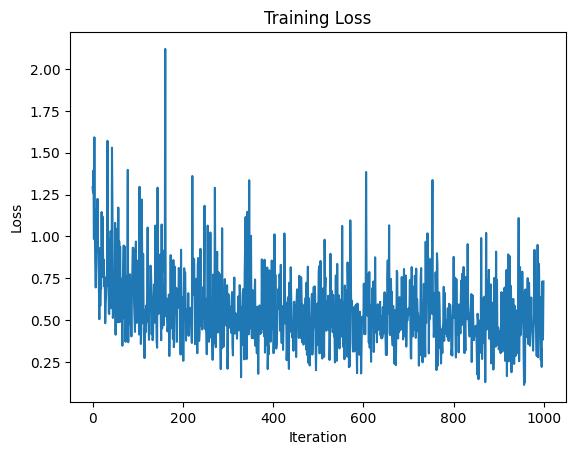

In [19]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [20]:
# Evaluation loop

losses = []
model.eval()
with torch.no_grad():
    for batch in eval_loader:
        input = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**input)
        loss = outputs.loss
        losses.append(loss.item())
        print(loss)

tensor(0.6108, device='cuda:0')
tensor(0.5377, device='cuda:0')
tensor(0.4803, device='cuda:0')
tensor(0.3345, device='cuda:0')
tensor(0.4113, device='cuda:0')
tensor(0.4291, device='cuda:0')
tensor(0.7709, device='cuda:0')
tensor(0.3984, device='cuda:0')
tensor(0.8109, device='cuda:0')
tensor(0.4173, device='cuda:0')
tensor(0.5379, device='cuda:0')
tensor(0.4637, device='cuda:0')
tensor(0.7145, device='cuda:0')
tensor(0.4647, device='cuda:0')
tensor(0.5110, device='cuda:0')
tensor(0.4873, device='cuda:0')
tensor(0.3368, device='cuda:0')
tensor(0.3986, device='cuda:0')
tensor(0.6407, device='cuda:0')
tensor(0.5788, device='cuda:0')
tensor(0.3696, device='cuda:0')
tensor(0.4696, device='cuda:0')
tensor(0.7211, device='cuda:0')
tensor(0.5555, device='cuda:0')
tensor(0.2560, device='cuda:0')
tensor(0.3979, device='cuda:0')
tensor(0.7775, device='cuda:0')
tensor(0.8358, device='cuda:0')
tensor(0.3423, device='cuda:0')
tensor(0.4458, device='cuda:0')
tensor(0.3594, device='cuda:0')
tensor(0

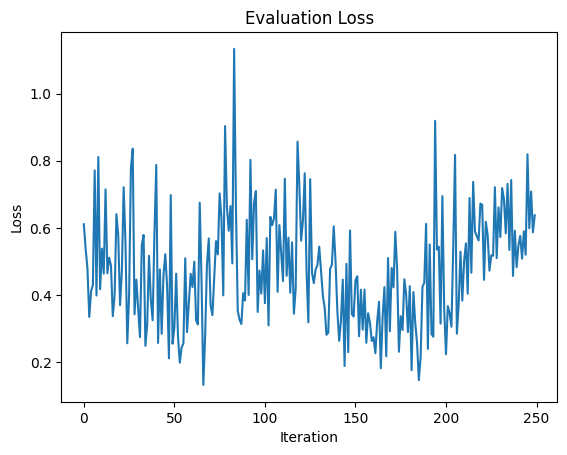

In [21]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Evaluation Loss")
plt.show()

In [ ]:
# save the model
directory = 'path_to_the_model_directory'

model.save_pretrained(directory)
tokenizer.save_pretrained(directory)

('/content/drive/MyDrive/Magistrale/Machine learning for software analysis/MLSA/Model/tokenizer_config.json',
 '/content/drive/MyDrive/Magistrale/Machine learning for software analysis/MLSA/Model/special_tokens_map.json',
 '/content/drive/MyDrive/Magistrale/Machine learning for software analysis/MLSA/Model/vocab.json',
 '/content/drive/MyDrive/Magistrale/Machine learning for software analysis/MLSA/Model/merges.txt',
 '/content/drive/MyDrive/Magistrale/Machine learning for software analysis/MLSA/Model/added_tokens.json')

# Inference

In [ ]:
# Import the model
!gdown --folder "https://drive.google.com/drive/folders/1-14DZR-ds0AZgeQqKtzTf5hNyGkNHj-1"

Retrieving folder contents
Processing file 1-3Gi1RfLXRr23mDMeHQD-zn-KIWhBSUc config.json
Processing file 1-8ySYaaguBwz9PKym5KRprAuSxETG4fC merges.txt
Processing file 1-5aTG7SM33yj8blDKpEFKA3Xw1ki-N0i model.safetensors
Processing file 1-JyQTIxMkpEomU39cGXA6Zubj-p8mdZs special_tokens_map.json
Processing file 1-MV-LuW38tPsqWorIAPTGsTTo_RdGx8O tokenizer_config.json
Processing file 1-EyCic4FIFKUhS_Glk_nvpMDexILo15i vocab.json
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-3Gi1RfLXRr23mDMeHQD-zn-KIWhBSUc
To: /content/Model/config.json
100% 710/710 [00:00<00:00, 4.43MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-8ySYaaguBwz9PKym5KRprAuSxETG4fC
To: /content/Model/merges.txt
100% 456k/456k [00:00<00:00, 134MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-5aTG7SM33yj8blDKpEFKA3Xw1ki-N0i
From (redirected): https://drive.google.com/uc?id=1-5aTG7SM33yj8b

In [ ]:
# reload the model
directory = '/content/Model'

model = RobertaForMaskedLM.from_pretrained(directory)
tokenizer = RobertaTokenizer.from_pretrained(directory)

In [ ]:
def print_result(outputs):
    table_data = []
    for output in outputs:
        token_str = f'"{output["token_str"]}"'  # Preserve leading spaces by wrapping in quotes
        table_data.append([output['sequence'], token_str, output['score']])

    print("The suggested code completions are:")
    print(tabulate(table_data, headers=["Completion", "Predicted token", "Score"], tablefmt="grid", colalign=("left", "left", "center")) )

In [ ]:
def code_completion(code_example, iterations: int = 1):
    '''
    - code_example: snipped of code that need to be code-completed. No token <mask> needed.
    - iterations: number of subsequent code completions to be generated.
                  Each sequence generated after the first one will be based only on the previous sequence with the highest score.
    '''
    code_example = code_example + "<mask>"
    fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)
    current_example = code_example  # Start with the initial code

    for _ in range(iterations):
        outputs = fill_mask(current_example)

        # Take the first prediction and append <mask> to continue completion
        best_prediction = outputs[0]["sequence"]
        current_example = best_prediction + " <mask>"
        print_result(outputs)
    return outputs

In [ ]:
result = code_completion("def is_zero(x): return x==")

Device set to use cuda:0


The suggested code completions are:
+--------------------------------+-------------------+------------+
| Completion                     | Predicted token   |   Score    |
+================================+===================+============+
| def is_zero(x): return x==0    | "0"               |  0.725383  |
+--------------------------------+-------------------+------------+
| def is_zero(x): return x== 0   | " 0"              |  0.178053  |
+--------------------------------+-------------------+------------+
| def is_zero(x): return x==x    | "x"               | 0.0419061  |
+--------------------------------+-------------------+------------+
| def is_zero(x): return x==zero | "zero"            |  0.011265  |
+--------------------------------+-------------------+------------+
| def is_zero(x): return x==1    | "1"               | 0.00624731 |
+--------------------------------+-------------------+------------+


In [ ]:
result = code_completion("def add(a, b): return a+")

Device set to use cuda:0


The suggested code completions are:
+----------------------------+-------------------+------------+
| Completion                 | Predicted token   |   Score    |
+============================+===================+============+
| def add(a, b): return a+b  | "b"               |   0.9766   |
+----------------------------+-------------------+------------+
| def add(a, b): return a+a  | "a"               | 0.00803229 |
+----------------------------+-------------------+------------+
| def add(a, b): return a+ b | " b"              | 0.00514298 |
+----------------------------+-------------------+------------+
| def add(a, b): return a+1  | "1"               | 0.00164974 |
+----------------------------+-------------------+------------+
| def add(a, b): return a+2  | "2"               | 0.00139649 |
+----------------------------+-------------------+------------+


In [ ]:
result = code_completion("def add(a, b): return a", 2)

Device set to use cuda:0


The suggested code completions are:
+---------------------------+-------------------+-----------+
| Completion                | Predicted token   |   Score   |
+===========================+===================+===========+
| def add(a, b): return a + | " +"              | 0.788156  |
+---------------------------+-------------------+-----------+
| def add(a, b): return a - | " -"              | 0.0473608 |
+---------------------------+-------------------+-----------+
| def add(a, b): return a   | "                 | 0.0304668 |
|                           | "                 |           |
+---------------------------+-------------------+-----------+
| def add(a, b): return a.  | "."               |  0.02006  |
+---------------------------+-------------------+-----------+
| def add(a, b): return a,  | ","               | 0.020017  |
+---------------------------+-------------------+-----------+
The suggested code completions are:
+-----------------------------+-------------------+---------

In [ ]:
result = code_completion("for element ", 2)

Device set to use cuda:0


The suggested code completions are:
+----------------+-------------------+-----------+
| Completion     | Predicted token   |   Score   |
+================+===================+===========+
| for element in | " in"             | 0.442312  |
+----------------+-------------------+-----------+
| for element_   | "_"               | 0.0344412 |
+----------------+-------------------+-----------+
| for elementIn  | "In"              | 0.0282872 |
+----------------+-------------------+-----------+
| for elementin  | "in"              | 0.0220934 |
+----------------+-------------------+-----------+
| for element()  | "()"              | 0.0185084 |
+----------------+-------------------+-----------+
The suggested code completions are:
+-------------------------+-------------------+-----------+
| Completion              | Predicted token   |   Score   |
+=========================+===================+===========+
| for element in elements | " elements"       | 0.466459  |
+------------------------